## Quasars vs Stars (Full Binary)


In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path


## Logistic Regression 

In [ ]:
# Load full cleaned data (paths from notebooks/full_binary/)
stars = pd.read_csv("../../data/full/stars_gaia_clean.csv").assign(label=0)
bhs = pd.read_csv("../../data/full/quasars_gaia_clean.csv").assign(label=1)

features = ["parallax", "pmra", "pmdec", "phot_g_mean_mag", "bp_rp"]

# for stars vs quasars 
sizes = [10000, 30000, 50000]

def eval_size_logreg(n_total, n_splits=100):
    n_per = min(n_total // 2, len(bhs), len(stars))
    stars_sub = stars.sample(n=n_per, random_state=42)
    bhs_sub = bhs.sample(n=n_per, random_state=42)
    df = pd.concat([stars_sub, bhs_sub], ignore_index=True)

    X = df[features].values
    y = df["label"].values

    splitter = StratifiedShuffleSplit(n_splits=n_splits, test_size=0.2, random_state=42)
    accs = []; precs = []; recs = []; f1s = []

    clf = make_pipeline(StandardScaler(), LogisticRegression(max_iter=2000, class_weight="balanced"))
    for train_idx, test_idx in splitter.split(X, y):
        clf.fit(X[train_idx], y[train_idx])
        y_pred = clf.predict(X[test_idx])
        accs.append(accuracy_score(y[test_idx], y_pred))
        p, r, f1, _ = precision_recall_fscore_support(
            y[test_idx], y_pred, average="binary", zero_division=0
        )
        precs.append(p); recs.append(r); f1s.append(f1)

    return {
        "size": 2 * n_per,
        "acc_mean": np.mean(accs),
        "prec_mean": np.mean(precs),
        "rec_mean": np.mean(recs),
        "f1_mean": np.mean(f1s),
    }

for size in sizes:
    print("LogReg", eval_size_logreg(size))

LogReg {'size': 10000, 'acc_mean': np.float64(0.9012600000000002), 'prec_mean': np.float64(0.8878261087237987), 'rec_mean': np.float64(0.9187200000000001), 'f1_mean': np.float64(0.9029636702799363)}
LogReg {'size': 30000, 'acc_mean': np.float64(0.9039266666666669), 'prec_mean': np.float64(0.8914324345840217), 'rec_mean': np.float64(0.9199266666666667), 'f1_mean': np.float64(0.9054415877963871)}
LogReg {'size': 50000, 'acc_mean': np.float64(0.9026299999999999), 'prec_mean': np.float64(0.8901968467629245), 'rec_mean': np.float64(0.9185859999999999), 'f1_mean': np.float64(0.9041580904619887)}


## RAndom Forest Classifier

In [3]:
def eval_size_rf(n_total, n_splits=100):
    n_per = min(n_total // 2, len(bhs), len(stars))
    stars_sub = stars.sample(n=n_per, random_state=42)
    bhs_sub = bhs.sample(n=n_per, random_state=42)
    df = pd.concat([stars_sub, bhs_sub], ignore_index=True)

    X = df[features].values
    y = df["label"].values

    splitter = StratifiedShuffleSplit(n_splits=n_splits, test_size=0.2, random_state=42)
    accs = []; precs = []; recs = []; f1s = []

    for train_idx, test_idx in splitter.split(X, y):
        clf = RandomForestClassifier(n_estimators=300, random_state=42, class_weight="balanced_subsample")
        clf.fit(X[train_idx], y[train_idx])
        y_pred = clf.predict(X[test_idx])
        accs.append(accuracy_score(y[test_idx], y_pred))
        p, r, f1, _ = precision_recall_fscore_support(
            y[test_idx], y_pred, average="binary", zero_division=0
        )
        precs.append(p); recs.append(r); f1s.append(f1)

    return {
        "size": 2 * n_per,
        "acc_mean": np.mean(accs),
        "prec_mean": np.mean(precs),
        "rec_mean": np.mean(recs),
        "f1_mean": np.mean(f1s),
    }
for size in sizes:
    print(eval_size_rf(size))

{'size': 10000, 'acc_mean': np.float64(0.9424899999999999), 'prec_mean': np.float64(0.9299348670128559), 'rec_mean': np.float64(0.95717), 'f1_mean': np.float64(0.9433300258180055)}
{'size': 30000, 'acc_mean': np.float64(0.9477966666666666), 'prec_mean': np.float64(0.934942019263426), 'rec_mean': np.float64(0.9625933333333333), 'f1_mean': np.float64(0.9485587503851716)}
{'size': 50000, 'acc_mean': np.float64(0.948091), 'prec_mean': np.float64(0.9352783266929798), 'rec_mean': np.float64(0.9628239999999999), 'f1_mean': np.float64(0.9488452926657089)}


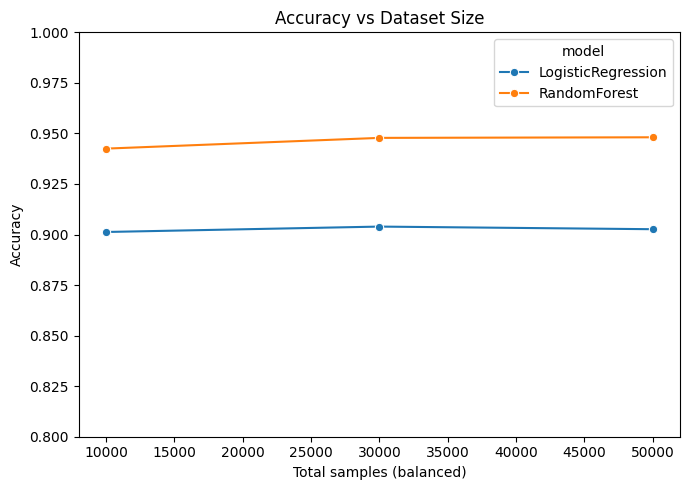

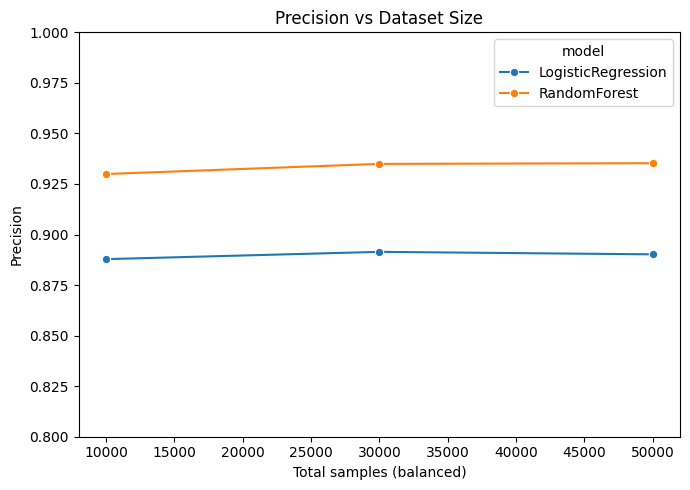

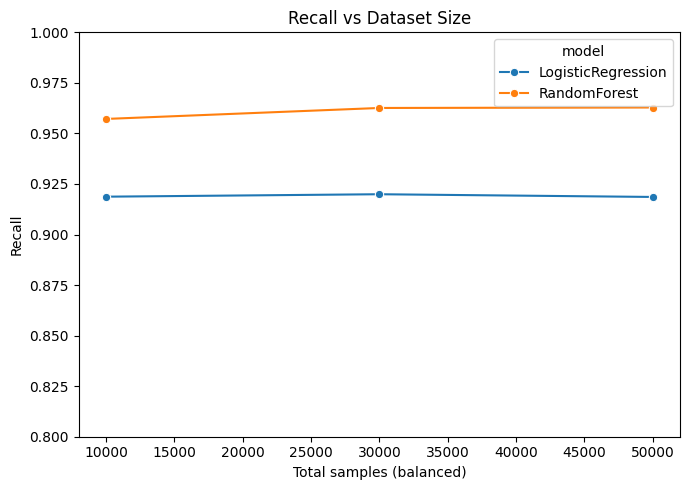

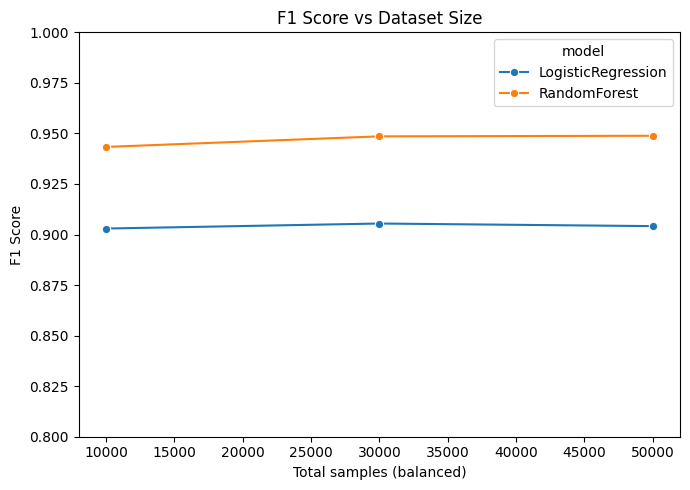

In [4]:
logreg_results = [eval_size_logreg(n) for n in sizes]
rf_results = [eval_size_rf(n) for n in sizes]

df_log = pd.DataFrame(logreg_results)
df_log["model"] = "LogisticRegression"

df_rf = pd.DataFrame(rf_results)
df_rf["model"] = "RandomForest"

df_plot = pd.concat([df_log, df_rf], ignore_index=True)

plot_dir = Path("../../Main_plots/binary_quasars_vs_stars")
plot_dir.mkdir(parents=True, exist_ok=True)

metrics = ["acc_mean", "prec_mean", "rec_mean", "f1_mean"]
titles = {
    "acc_mean": "Accuracy",
    "prec_mean": "Precision",
    "rec_mean": "Recall",
    "f1_mean": "F1 Score",
}

for m in metrics:
    plt.figure(figsize=(7,5))
    sns.lineplot(data=df_plot, x="size", y=m, hue="model", marker="o")
    plt.title(f"{titles[m]} vs Dataset Size")
    plt.xlabel("Total samples (balanced)")
    plt.ylabel(titles[m])
    plt.ylim(0.8, 1.0)
    plt.tight_layout()
    plt.savefig(plot_dir / f"{m}_vs_size.png", dpi=200, bbox_inches="tight")
    plt.show()
    plt.close()
